In [1]:
import os, joblib
import xgboost as xgb
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GroupShuffleSplit, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.utils import resample
# from imblearn.over_sampling import SMOTE
# from imblearn.ensemble import BalancedRandomForestClassifier

/home/administrator/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Define Data directory
DATA_DIR = '../data/'

# list of poet names
# Removed the 5 lowest poets
poets = ["abbasinYousuf", "ajmalKhattak", "allamaAbdulHai", "ghaniKhan", "hamzaBaba", "javedAhmedzai", "karanKhan", "khatirAfridi", "khushalKhanKhattak", "matiullahTurab", "mumtazOrakazi", "munirJan", "naeemAhmed", "rabiaMumtaz", "rahmanBaba", "rehmatShah", "sahibShahSabir", "shabbirKhanDurrani", "shakirOrakzai", "shoaibKhanKhattak"]

# # Pehle k 13
# poets = ["abbasinYousuf", "azizMazerwal", "ghaniKhan", "hamzaBaba", "khaliqZiari", "khatirAfridi", "khushalKhanKhattak",  "mumtazOrakazi", "munirJan",  "rahmanBaba", "rehmatShah", "sahibShahSabir", "salimRiaz"]

## All
# poets = ["abbasinYousuf", "azizMazerwal", "ghaniKhan", "hamzaBaba", "karanKhan", "khaliqZiari", "khatirAfridi", "khushalKhanKhattak", "matiullahTurab", "mumtazOrakazi", "munirJan", "naeemAhmed", "rabiaMumtaz", "rahmanBaba", "rehmatShah", "sahibShahSabir", "salimRiaz"]

poet_labels = {poet: i for i, poet in enumerate(poets)}
print(poet_labels)

{'abbasinYousuf': 0, 'ajmalKhattak': 1, 'allamaAbdulHai': 2, 'ghaniKhan': 3, 'hamzaBaba': 4, 'javedAhmedzai': 5, 'karanKhan': 6, 'khatirAfridi': 7, 'khushalKhanKhattak': 8, 'matiullahTurab': 9, 'mumtazOrakazi': 10, 'munirJan': 11, 'naeemAhmed': 12, 'rabiaMumtaz': 13, 'rahmanBaba': 14, 'rehmatShah': 15, 'sahibShahSabir': 16, 'shabbirKhanDurrani': 17, 'shakirOrakzai': 18, 'shoaibKhanKhattak': 19}


In [3]:
# Load and Label the Data
def load_and_label(data_dir, poets, poet_labels):
    data = []
    labels = []

    for poet in poets:
        poet_dir = os.path.join(data_dir, poet)
        file_path = os.path.join(poet_dir, f'{poet}.txt')

        # Check if the file exists
        if not os.path.exists(file_path):
            print(f'{file_path} does not exist')
            continue

        with open(file_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()
            data.extend(lines)
            labels.extend([poet_labels[poet]] * len(lines))

    df = pd.DataFrame({'text': data, 'label': labels})
    return data, labels, df

In [4]:
data, labels, df = load_and_label(DATA_DIR, poets, poet_labels)
df.describe()

,label
count,54620.000000
mean,8.625265
std,5.352617
min,0.000000
25%,4.000000
50%,8.000000
75%,14.000000
max,19.000000


In [ ]:
# def balance_data(df):
#     max_size = df['label'].value_counts().max()
#     lst = [df]
#     for class_index, group in df.groupby('label'):
#         lst.append(group.sample(max_size-len(group), replace=True))
#     df_balanced = pd.concat(lst)
#     return df_balanced.sample(frac=1).reset_index(drop=True)

In [ ]:
# df_balanced = balance_data(df)

In [5]:
def weighted_train_test_split(df, test_size=0.2, random_state=42):
    train_dfs = []
    test_dfs = []

    # Split each poet's data individually
    for poet_label in df['label'].unique():
        poet_df = df[df['label'] == poet_label]
        train_poet, test_poet = train_test_split(
            poet_df, test_size=test_size, random_state=random_state, stratify=poet_df['label']
        )
        train_dfs.append(train_poet)
        test_dfs.append(test_poet)

    # Concatenate all individual splits to get the final training and testing dataframes
    train_df = pd.concat(train_dfs).sample(frac=1, random_state=random_state).reset_index(drop=True)
    test_df = pd.concat(test_dfs).sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    return train_df, test_df

In [6]:
# Modified extract_features function
def extract_features(df, tfidf_vectorizer=None, num_features=None):
    if tfidf_vectorizer is None:
        tfidf_vectorizer = TfidfVectorizer(max_features=num_features)
        X = tfidf_vectorizer.fit_transform(df['text']).toarray()
    else:
        X = tfidf_vectorizer.transform(df['text']).toarray()
    y = df['label'].values
    return X, y, tfidf_vectorizer

In [ ]:
def extract_features(df, num_features=None):
    tfidf_vectorizer = TfidfVectorizer(max_features=num_features)
    # tfidf_vectorizer = TfidfVectorizer(max_features=5000)
    X = tfidf_vectorizer.fit_transform(df['text']).toarray()
    y = df['label'].values
    return X, y, tfidf_vectorizer

In [9]:
# train_df, test_df = weighted_train_test_split(df, test_size=0.2)
# X_train, y_train, tfidf_vectorizer = extract_features(train_df, 5000)
# X_test, y_test, _ = extract_features(test_df, 5000)
# train_df, test_df = weighted_train_test_split(df_balanced, test_size=0.2)
train_df, test_df = weighted_train_test_split(df, test_size=0.2)
X_train, y_train, tfidf_vectorizer = extract_features(train_df, num_features=10000)  # Fit vectorizer on training data
X_test, y_test, _ = extract_features(test_df, tfidf_vectorizer=tfidf_vectorizer)  # Use same vectorizer for test data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((43689, 10000), (10931, 10000), (43689,), (10931,))

In [10]:
# Check the split results
print(f"Training set size: {len(train_df)} samples")
print(f"Testing set size: {len(test_df)} samples")
print(f"Number of features: {X_train.shape[1]}")
print(f"Class distribution in training set:\n{train_df['label'].value_counts(normalize=True)}")
print(f"Class distribution in testing set:\n{test_df['label'].value_counts(normalize=True)}")

Training set size: 43689 samples
Testing set size: 10931 samples
Number of features: 10000
Class distribution in training set:
label
8     0.155897
2     0.087162
14    0.080661
0     0.068667
10    0.060244
15    0.056170
7     0.052599
3     0.051226
9     0.043672
4     0.043123
11    0.042825
17    0.038660
16    0.038499
6     0.035844
12    0.031335
1     0.028566
19    0.022523
13    0.020943
18    0.020852
5     0.020531
Name: proportion, dtype: float64
Class distribution in testing set:
label
8     0.155795
2     0.087183
14    0.080596
0     0.068612
10    0.060287
15    0.056171
7     0.052603
3     0.051230
9     0.043637
4     0.043088
11    0.042814
17    0.038697
16    0.038514
6     0.035861
12    0.031379
1     0.028634
19    0.022505
13    0.020950
18    0.020858
5     0.020584
Name: proportion, dtype: float64


In [ ]:
# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
# X, y, tfidf_vectorizer = extract_features(df)
# X, y, tfidf_vectorizer = extract_features(df, 15000)
X, y, tfidf_vectorizer = extract_features(df, 5000)
# X, y, tfidf_vectorizer = extract_features(df_balanced, 5000)

In [ ]:
print(f"Number of samples: {len(df)}")
print(f"Number of features (TF-IDF): {X.shape[1]}")
print(f"Class distribution:\n{df['label'].value_counts()}")
# print(f"Number of samples: {len(df_balanced)}")
# print(f"Number of features (TF-IDF): {X.shape[1]}")
# print(f"Class distribution:\n{df_balanced['label'].value_counts()}")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

#### Random Forest

In [11]:
rf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
# rf = RandomForestClassifier(n_estimators=1000, max_depth=None, random_state=42)

print(f"Training the Random Forest model...")
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print(f"Training and Predicting Done!")

Training the Random Forest model...
Training and Predicting Done!



Model Performance and Evaluation
Accuracy: 51.93%
F1 Score (Weighted): 0.5012
Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.47      0.38       750
           1       0.41      0.19      0.26       313
           2       0.60      0.73      0.66       953
           3       0.40      0.34      0.37       560
           4       0.35      0.44      0.39       471
           5       0.45      0.15      0.23       225
           6       0.31      0.29      0.30       392
           7       0.44      0.44      0.44       575
           8       0.67      0.89      0.77      1703
           9       0.64      0.57      0.60       477
          10       0.47      0.59      0.52       659
          11       0.51      0.49      0.50       468
          12       0.39      0.31      0.34       343
          13       0.29      0.13      0.18       229
          14       0.64      0.59      0.61       881
          15       0.67      0.60

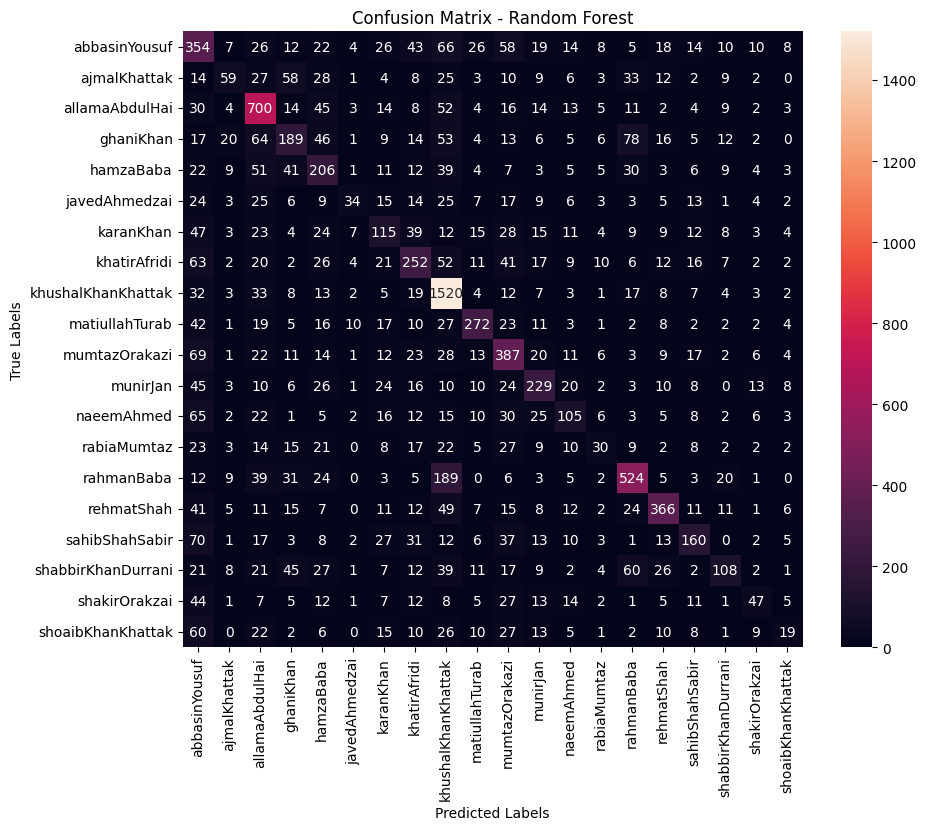

In [12]:
# Evaluation
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
conf_mat_rf = confusion_matrix(y_test, y_pred_rf)

# Print Metrics
print("\nModel Performance and Evaluation")
# print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Accuracy: {accuracy_rf*100:.2f}%")
print(f"F1 Score (Weighted): {f1_rf:.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_rf)}")

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_rf, annot=True, fmt='d', xticklabels=poets, yticklabels=poets)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Random Forest')
plt.show()

#### Support Vector Machine

In [13]:
# SVM Model
svm = SVC(kernel='linear', random_state=42)

# Training and predictions
print(f"Training the SVM model...")
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)
print(f"Training and Predicting Done!")

Training the SVM model...
Training and Predicting Done!



Model Performance and Evaluation
Accuracy: 60.71%
F1 Score (Weighted): 0.5959
Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.56      0.45       750
           1       0.57      0.37      0.45       313
           2       0.64      0.83      0.73       953
           3       0.49      0.52      0.50       560
           4       0.50      0.42      0.46       471
           5       0.57      0.28      0.38       225
           6       0.38      0.38      0.38       392
           7       0.55      0.54      0.54       575
           8       0.77      0.91      0.84      1703
           9       0.54      0.54      0.54       477
          10       0.65      0.68      0.66       659
          11       0.57      0.48      0.52       468
          12       0.51      0.42      0.46       343
          13       0.58      0.26      0.36       229
          14       0.75      0.77      0.76       881
          15       0.74      0.71

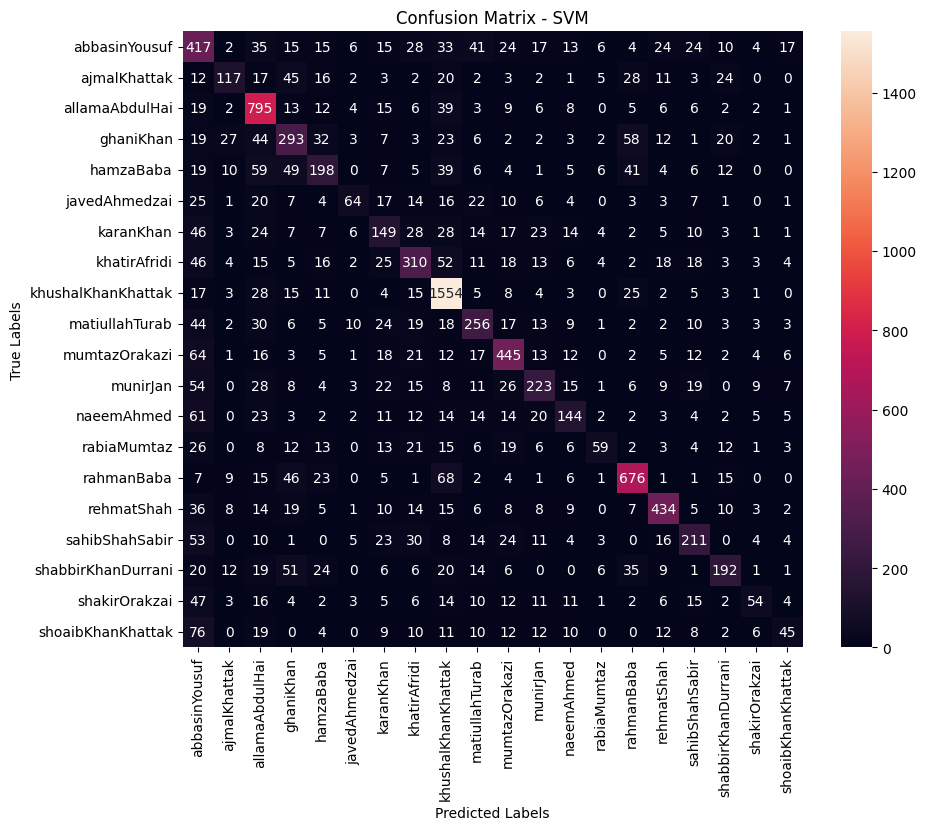

In [14]:
# Evaluation
accuracy_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')
conf_mat_svm = confusion_matrix(y_test, y_pred_svm)

# Print Metrics
print("\nModel Performance and Evaluation")
# print(f"Accuracy: {accuracy_svm:.4f}")
print(f"Accuracy: {accuracy_svm*100:.2f}%")
print(f"F1 Score (Weighted): {f1_svm:.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_svm)}")

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_svm, annot=True, fmt='d', xticklabels=poets, yticklabels=poets)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - SVM')
plt.show()

In [15]:
# SVM Model
svm = SVC(C=1.0, kernel='rbf', gamma='scale', probability=True, random_state=42)

# Training and predictions
print(f"Training the SVM model...")
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)
print(f"Training and Predicting Done!")

Training the SVM model...
Training and Predicting Done!



Model Performance and Evaluation
Accuracy: 61.92%
F1 Score (Weighted): 0.6026
Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.62      0.46       750
           1       0.75      0.28      0.41       313
           2       0.63      0.85      0.72       953
           3       0.49      0.52      0.51       560
           4       0.51      0.44      0.47       471
           5       0.73      0.24      0.36       225
           6       0.48      0.38      0.42       392
           7       0.58      0.55      0.56       575
           8       0.73      0.94      0.82      1703
           9       0.63      0.61      0.62       477
          10       0.68      0.69      0.68       659
          11       0.67      0.53      0.59       468
          12       0.55      0.38      0.45       343
          13       0.61      0.21      0.32       229
          14       0.72      0.77      0.75       881
          15       0.74      0.73

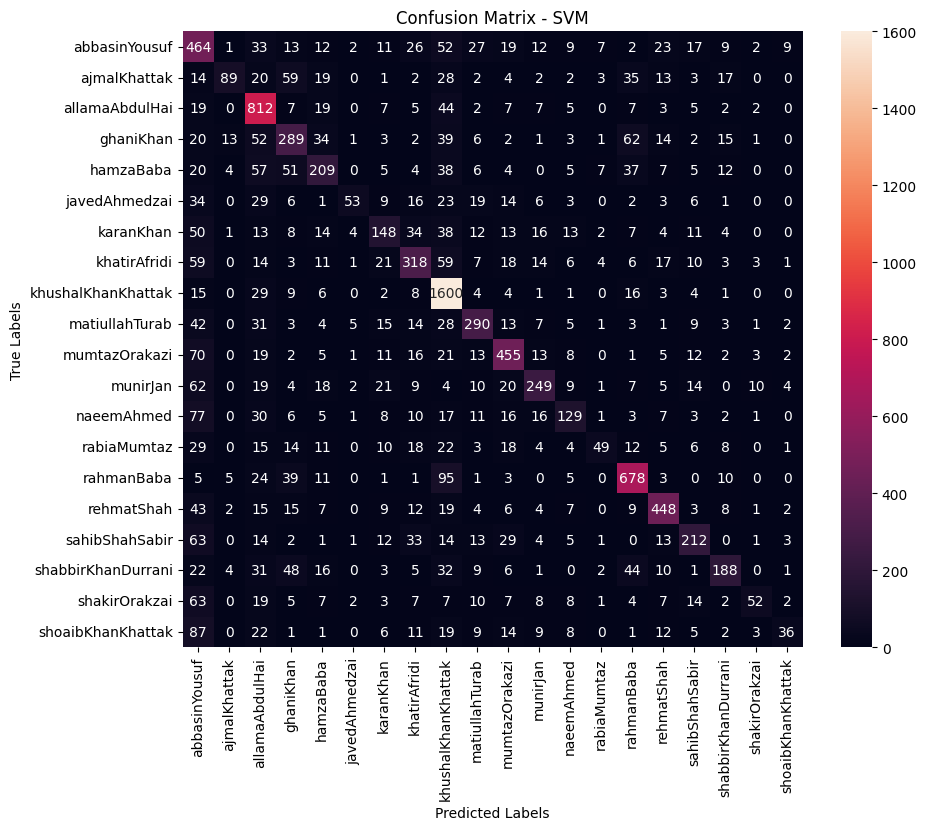

In [16]:
# Evaluation
accuracy_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')
conf_mat_svm = confusion_matrix(y_test, y_pred_svm)

# Print Metrics
print("\nModel Performance and Evaluation")
# print(f"Accuracy: {accuracy_svm:.4f}")
print(f"Accuracy: {accuracy_svm*100:.2f}%")
print(f"F1 Score (Weighted): {f1_svm:.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_svm)}")

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_svm, annot=True, fmt='d', xticklabels=poets, yticklabels=poets)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - SVM')
plt.show()

#### Logistic Regression

In [17]:
log_reg = LogisticRegression(max_iter=1000)

print(f"Training the Logistic Regression model...")
log_reg.fit(X_train, y_train)

y_pred_log_reg = log_reg.predict(X_test)
print(f"Training and Predicting Done!")

Training the Logistic Regression model...
Training and Predicting Done!



Model Performance and Evaluation
Accuracy: 0.5983%
F1 Score (Weighted): 0.5768
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.52      0.45       750
           1       0.66      0.31      0.42       313
           2       0.61      0.85      0.71       953
           3       0.52      0.50      0.51       560
           4       0.52      0.34      0.41       471
           5       0.64      0.23      0.33       225
           6       0.45      0.33      0.38       392
           7       0.56      0.54      0.55       575
           8       0.72      0.94      0.81      1703
           9       0.51      0.53      0.52       477
          10       0.61      0.69      0.65       659
          11       0.56      0.48      0.51       468
          12       0.52      0.39      0.45       343
          13       0.58      0.19      0.29       229
          14       0.69      0.78      0.73       881
          15       0.65      0.7

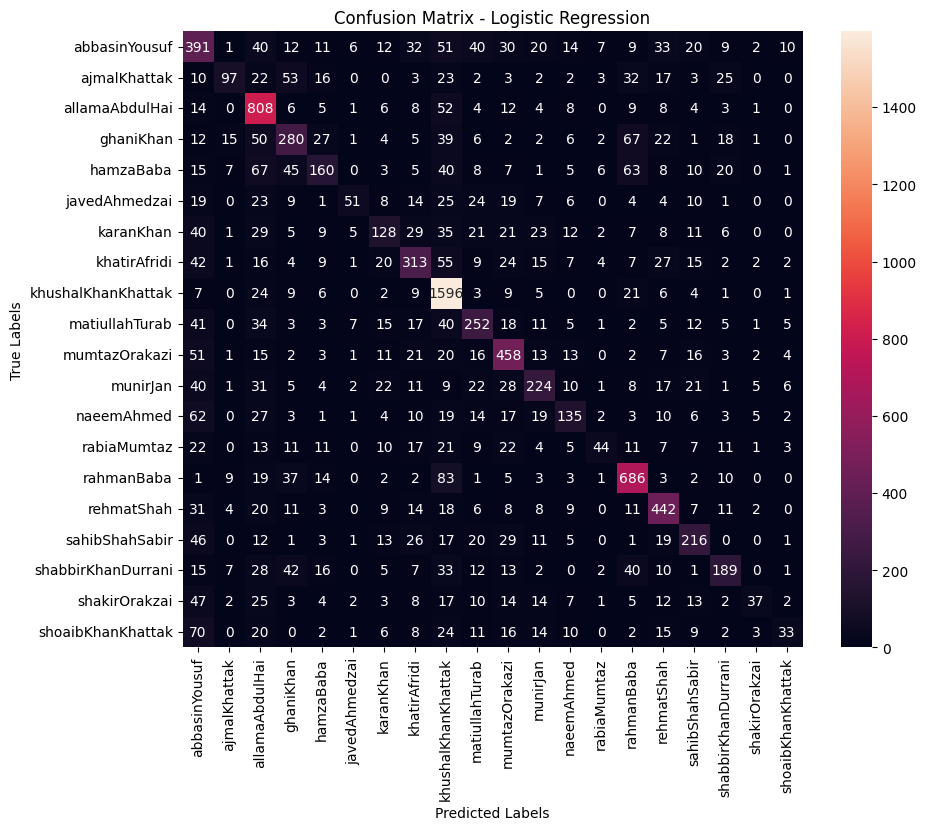

In [18]:
# Evaluation
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
f1_log_reg = f1_score(y_test, y_pred_log_reg, average='weighted')
conf_mat_log_reg = confusion_matrix(y_test, y_pred_log_reg)

# Print Metrics
print("\nModel Performance and Evaluation")
print(f"Accuracy: {accuracy_log_reg:.4f}%")
print(f"F1 Score (Weighted): {f1_log_reg:.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_log_reg)}")

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_log_reg, annot=True, fmt='d', xticklabels=poets, yticklabels=poets)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

In [19]:
log_reg = LogisticRegression(max_iter=1000, solver='liblinear')

print(f"Training the Logistic Regression model...")
log_reg.fit(X_train, y_train)

y_pred_log_reg = log_reg.predict(X_test)
print(f"Training and Predicting Done!")

Training the Logistic Regression model...
Training and Predicting Done!



Model Performance and Evaluation
Accuracy: 0.5904%
F1 Score (Weighted): 0.5651
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.53      0.46       750
           1       0.70      0.29      0.41       313
           2       0.59      0.85      0.70       953
           3       0.52      0.48      0.50       560
           4       0.52      0.30      0.38       471
           5       0.63      0.19      0.29       225
           6       0.45      0.31      0.37       392
           7       0.56      0.53      0.54       575
           8       0.69      0.95      0.80      1703
           9       0.52      0.52      0.52       477
          10       0.59      0.69      0.63       659
          11       0.58      0.47      0.51       468
          12       0.54      0.38      0.45       343
          13       0.57      0.17      0.26       229
          14       0.67      0.77      0.72       881
          15       0.64      0.7

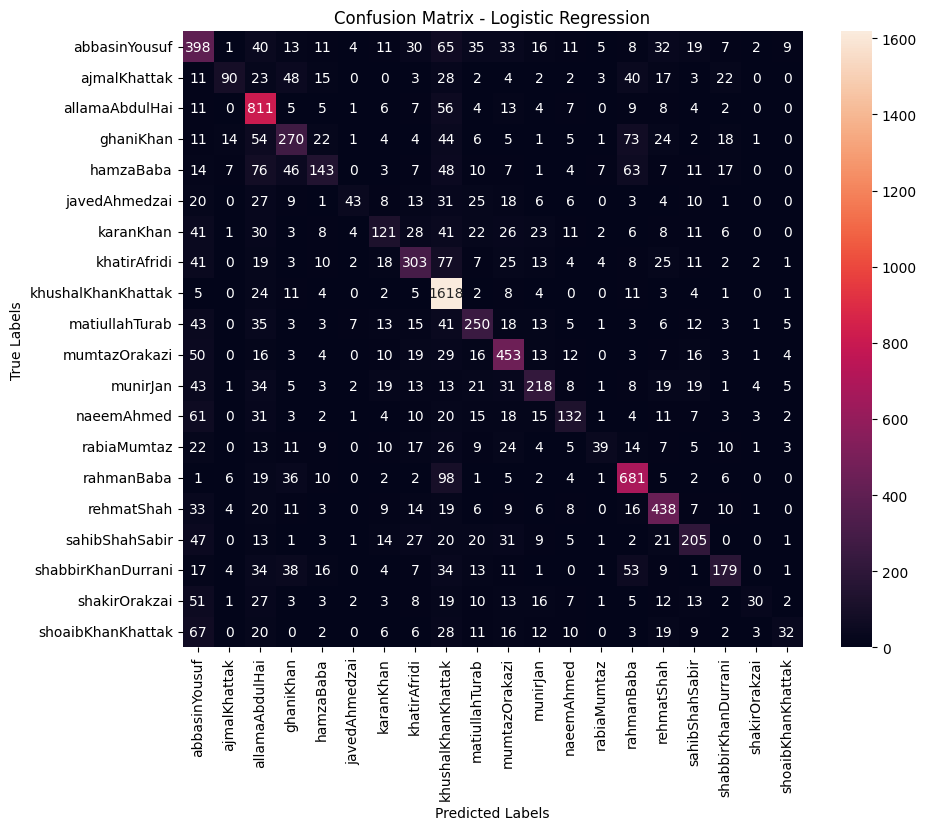

In [20]:
# Evaluation
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
f1_log_reg = f1_score(y_test, y_pred_log_reg, average='weighted')
conf_mat_log_reg = confusion_matrix(y_test, y_pred_log_reg)

# Print Metrics
print("\nModel Performance and Evaluation")
print(f"Accuracy: {accuracy_log_reg:.4f}%")
print(f"F1 Score (Weighted): {f1_log_reg:.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_log_reg)}")

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_log_reg, annot=True, fmt='d', xticklabels=poets, yticklabels=poets)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

In [21]:
log_reg = LogisticRegression(C=10, max_iter=1000, solver='newton-cg')

print(f"Training the Logistic Regression model...")
log_reg.fit(X_train, y_train)

y_pred_log_reg = log_reg.predict(X_test)
print(f"Training and Predicting Done!")

Training the Logistic Regression model...
Training and Predicting Done!



Model Performance and Evaluation
Accuracy: 0.6288%
F1 Score (Weighted): 0.6219
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.50      0.48       750
           1       0.54      0.42      0.47       313
           2       0.71      0.82      0.76       953
           3       0.53      0.53      0.53       560
           4       0.47      0.45      0.46       471
           5       0.49      0.35      0.41       225
           6       0.42      0.41      0.41       392
           7       0.56      0.57      0.57       575
           8       0.83      0.91      0.87      1703
           9       0.60      0.61      0.60       477
          10       0.69      0.69      0.69       659
          11       0.55      0.54      0.54       468
          12       0.50      0.46      0.48       343
          13       0.47      0.37      0.42       229
          14       0.75      0.78      0.77       881
          15       0.71      0.7

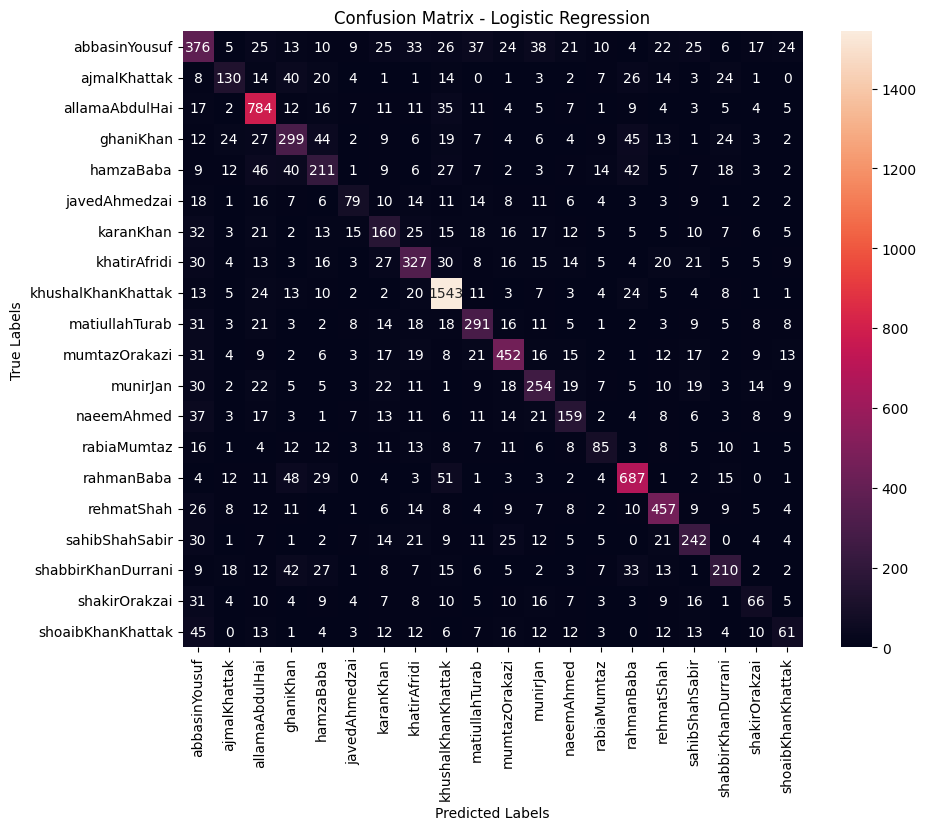

In [22]:
# Evaluation
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
f1_log_reg = f1_score(y_test, y_pred_log_reg, average='weighted')
conf_mat_log_reg = confusion_matrix(y_test, y_pred_log_reg)

# Print Metrics
print("\nModel Performance and Evaluation")
print(f"Accuracy: {accuracy_log_reg:.4f}%")
print(f"F1 Score (Weighted): {f1_log_reg:.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_log_reg)}")

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_log_reg, annot=True, fmt='d', xticklabels=poets, yticklabels=poets)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

#### Gradient Boosting

In [ ]:
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1 max_depth=3, random_state=42)

print(f"Training the Gradient Boosting model...")
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)
print(f"Training and Predicting Done!")

In [ ]:
# Evaluation
accuracy_gb = accuracy_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb, average='weighted')
conf_mat_gb = confusion_matrix(y_test, y_pred_gb)

# Print Metrics
print("\nModel Performance and Evaluation")
print(f"Accuracy: {accuracy_gb:.4f}%")
print(f"F1 Score (Weighted): {f1_gb:.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_gb)}")

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_gb, annot=True, fmt='d', xticklabels=poets, yticklabels=poets)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Gradient Boosting')
plt.show()

#### XGBoost

In [23]:
# xgboost = xgb.XGBClassifier(objective='multi:softmax', random_state=42)
xgboost = xgb.XGBClassifier(scale_pos_weight=1, n_estimators=100, learning_rate=0.1, max_depth=3, gamma=0.1, eval_metric='logloss', random_state=42)

print(f"Training the XGBoost model...")
xgboost.fit(X_train, y_train)

y_pred_xgboost = xgboost.predict(X_test)
print(f"Training and Predicting Done!")

Training the XGBoost model...


/home/administrator/.local/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:22:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training and Predicting Done!



Model Performance and Evaluation
Accuracy: 0.4167%
F1 Score (Weighted): 0.3830
Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.40      0.33       750
           1       0.52      0.17      0.26       313
           2       0.28      0.80      0.42       953
           3       0.40      0.19      0.25       560
           4       0.49      0.11      0.19       471
           5       0.48      0.11      0.17       225
           6       0.34      0.17      0.22       392
           7       0.44      0.33      0.38       575
           8       0.47      0.87      0.61      1703
           9       0.42      0.21      0.28       477
          10       0.44      0.43      0.44       659
          11       0.68      0.20      0.31       468
          12       0.51      0.20      0.29       343
          13       0.32      0.13      0.18       229
          14       0.62      0.51      0.56       881
          15       0.59      0.4

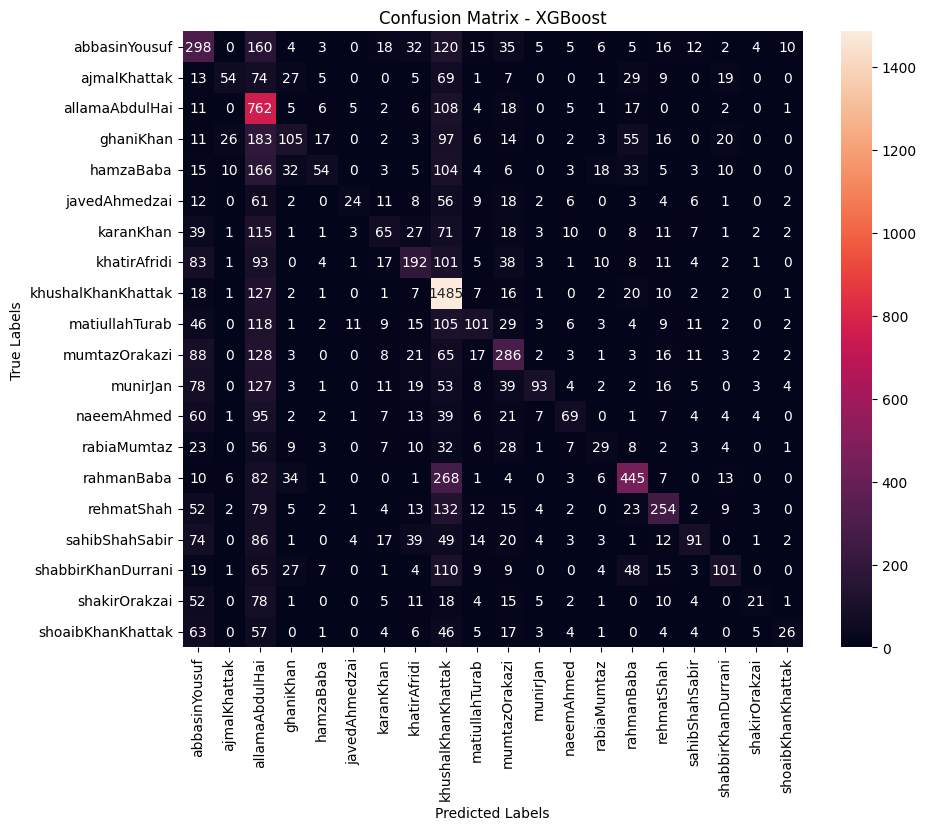

In [24]:
# Evaluation
accuracy_xgboost = accuracy_score(y_test, y_pred_xgboost)
f1_xgboost = f1_score(y_test, y_pred_xgboost, average='weighted')
conf_mat_xgboost = confusion_matrix(y_test, y_pred_xgboost)

# Print Metrics
print("\nModel Performance and Evaluation")
print(f"Accuracy: {accuracy_xgboost:.4f}%")
print(f"F1 Score (Weighted): {f1_xgboost:.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_xgboost)}")

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_xgboost, annot=True, fmt='d', xticklabels=poets, yticklabels=poets)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - XGBoost')
plt.show()

In [25]:
# xgboost = xgb.XGBClassifier(objective='multi:softmax', random_state=42)
xgboost = xgb.XGBClassifier(objective='multi:softmax', scale_pos_weight=1, n_estimators=100, learning_rate=0.1, max_depth=3, gamma=0.1, eval_metric='logloss', random_state=42)

print(f"Training the XGBoost model...")
xgboost.fit(X_train, y_train)

y_pred_xgboost = xgboost.predict(X_test)
print(f"Training and Predicting Done!")

Training the XGBoost model...


/home/administrator/.local/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:28:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training and Predicting Done!



Model Performance and Evaluation
Accuracy: 0.4167%
F1 Score (Weighted): 0.3830
Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.40      0.33       750
           1       0.52      0.17      0.26       313
           2       0.28      0.80      0.42       953
           3       0.40      0.19      0.25       560
           4       0.49      0.11      0.19       471
           5       0.48      0.11      0.17       225
           6       0.34      0.17      0.22       392
           7       0.44      0.33      0.38       575
           8       0.47      0.87      0.61      1703
           9       0.42      0.21      0.28       477
          10       0.44      0.43      0.44       659
          11       0.68      0.20      0.31       468
          12       0.51      0.20      0.29       343
          13       0.32      0.13      0.18       229
          14       0.62      0.51      0.56       881
          15       0.59      0.4

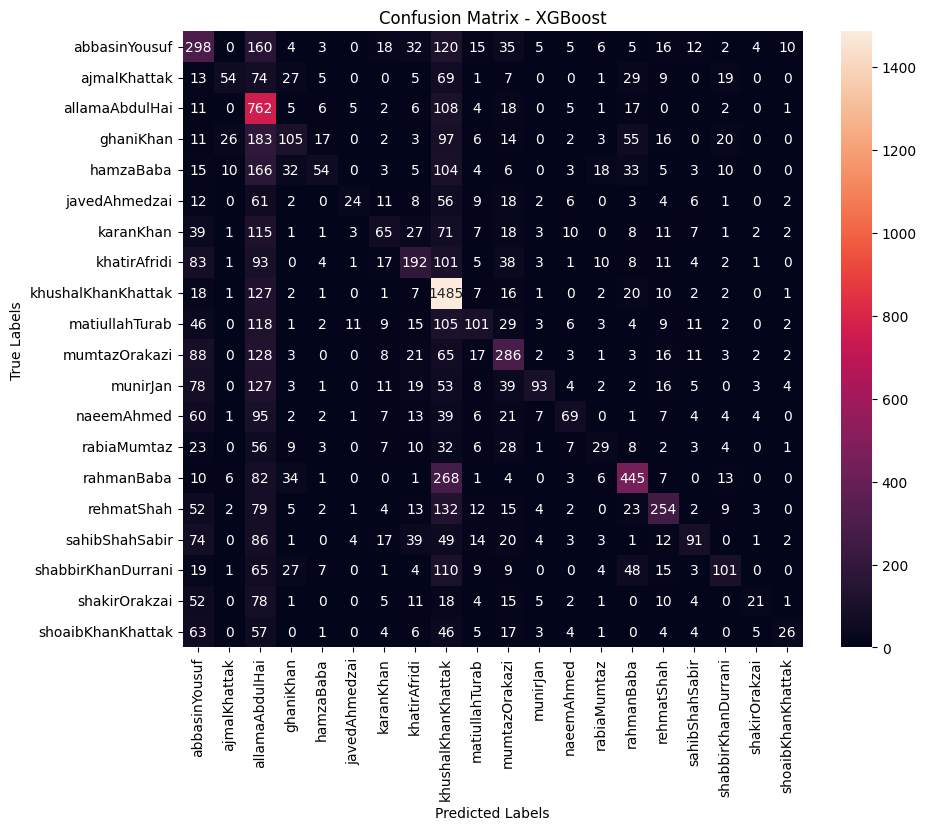

In [26]:
# Evaluation
accuracy_xgboost = accuracy_score(y_test, y_pred_xgboost)
f1_xgboost = f1_score(y_test, y_pred_xgboost, average='weighted')
conf_mat_xgboost = confusion_matrix(y_test, y_pred_xgboost)

# Print Metrics
print("\nModel Performance and Evaluation")
print(f"Accuracy: {accuracy_xgboost:.4f}%")
print(f"F1 Score (Weighted): {f1_xgboost:.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_xgboost)}")

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_xgboost, annot=True, fmt='d', xticklabels=poets, yticklabels=poets)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - XGBoost')
plt.show()